# Re-program by Dipankar Bhowmik (Exploratory Data Analysis)
### Date: 17-09-2020

# Problem description

This directory contains data to train a model to predict the function of protein domains, based on the PFam dataset.
Domains are functional sub-parts of proteins; much like images in ImageNet are pre segmented to contain exactly one object class, this data is presegmented to contain exactly and only one domain.
The purpose of the dataset is to repose the PFam seed dataset as a multiclass classification machine learning task.
The task is: given the amino acid sequence of the protein domain, predict which class it belongs to. There are about 1 million training examples, and 18,000 output classes.

# Data structure
This data is more completely described by the publication "Can Deep Learning Classify the Protein Universe", Bileschi et al.
## Data split and layout
The approach used to partition the data into training/dev/testing folds is a random split.
* Training data should be used to train your models.
* Dev (development) data should be used in a close validation loop (maybe for hyperparameter tuning or model validation).
* Test data should be reserved for much less frequent evaluations - this helps avoid overfitting on your test data, as it should only be used infrequently.

## File content
Each fold (train, dev, test) has a number of files in it. Each of those files contains csv on each line, which has the following fields:

<pre>sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
</pre>

Description of fields: 
- sequence: These are usually the input features to your model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z. 
- family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits. 
- family_id: One word name for family. 
- sequence_name: Sequence name, in the form "uniprot_accession_id/start_index-and end_index". 
- aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

Generally, the family_accession field is the label, and the sequence (or aligned sequence) is the training feature.
This sequence corresponds to a domain, not a full protein.
The contents of these fields is the same as to the data provided in Stockholm format by PFam at ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam32.0/Pfam-A.seed.gz


# EDA

In [ ]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # Decorate an iterable object, returning an iterator which acts exactly like the original iterable, 
                      # but prints a dynamically updating progressbar every time a value is requested
import re # used to work with Regular Expressions.
import matplotlib.pyplot as plt # Python 2D plotting library
import seaborn as sns #Seaborn is a library for making statistical graphics in Python
from pandas.plotting import table # Basic Plotting
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features
import time # provides various time-related functions
from datetime import timedelta #timedelta:- A duration expressing the difference between two date, time, or datetime.
from google.colab import drive # Downloading Datasets into Google Drive via Google Colab
from collections import Counter # It allows you to count the items in an iterable list
from keras.preprocessing.sequence import pad_sequences #Takes in a sequence of data-points gathered at equal intervals, along with time series parameters
                                                       #such as stride, length of history, etc., to produce batches for training/validation
from keras.utils import to_categorical  # It is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
from sklearn.preprocessing import LabelEncoder # Convert categorical values into numerical values, used to encode target values, i.e. y
import random # It implements pseudo-random number generators for various distributions

In [ ]:
import tensorflow as tf # Software library 
from tensorflow import keras # TensorFlow's high-level API for building and training deep learning models.
from tensorflow.keras.utils import plot_model # Converts a Keras model to dot format and save to a file
from tensorflow.keras import layers #  A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs.

In [ ]:
# Restart runtime using 'Runtime' -> 'Restart runtime...'
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
#Functions to save objects for future usage and repossess
#https://stackoverflow.com/questions/1253528/is-there-an-easy-way-to-pickle-a-python-function-or-otherwise-serialize-its-cod
import pickle
def transmit(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def receive(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [ ]:
drive.mount('/content/drive') # for mounting Google Drive files 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### Loading the data

In [ ]:
## code sourc https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split
## List out the available directories in the path
print('Available dataset partitions: ', os.listdir('drive/My Drive/Colab Notebooks'))

Available dataset partitions:  ['train_600_onehot.p', 'test_600_onehot.p', 'dev_600_onehot.p', 'train_600_ydata.p', 'test_600_ydata.p', 'dev_600_ydata.p', 'Annotation_of_Protein_by_Deep_Learning_15_05_2020.ipynb', 'Load images.ipynb', 'Untitled1.ipynb', 'train_ASCII_100_pad.p', 'test_ASCII_100_pad.p', 'dev_ASCII_100_pad.p', 'Untitled2.ipynb', 'Untitled (2)', 'pandas_basics_practice.ipynb', 'LIVE_Pandas.ipynb', 'LIVE-1_Python (1).ipynb', 'k.p', 'Untitled (1)', 'Untitled3.ipynb', 'Reference.ipynb', 'Implementing neural machine translation using keras.ipynb', 'Untitled4.ipynb', 'Annotation_of_Protein_by_Deep_Learning_31_05_2020_fit_generator.ipynb', 'fit_gen_sample.ipynb', 'Untitled0_6th_08_2020.ipynb', 'Untitled5.ipynb', 'Untitled0.ipynb', 'Untitled0_1.ipynb', 'test.p', 'dev.p', 'train.p', 'Untitled6.ipynb', 'Untitled', 'running.ipynb', 'Untitled7.ipynb', 'Annotation_of_Protein_by_Deep_Learning_19_08_2020_fit_generator.ipynb', 'Untitled8.ipynb', 'Annotation_of_Protein_by_Deep_Learning_31

In [ ]:
# Reading the content of the folder Development by creating function 'read_all_shards'

def read_all_shards(partition='dev', data_dir='drive/My Drive/Colab Notebooks'):
    shards = []
    ## Returns a list containing the names of the entries in the directory given by path "data_dir".
    for fn in os.listdir(os.path.join(data_dir, partition)):
        ## join and open given path "data_dir" components intelligently.
        with open(os.path.join(data_dir, partition, fn)) as f: ## here f is a file handler
            ## Read and append every file with skipping "aligned_sequence" column
            shards.append(pd.read_csv(f, usecols = lambda column : column not in["aligned_sequence"]))
    return pd.concat(shards)

## Building the respective ('dev', 'test', 'train') the files
test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

## Calcutlating the no. of sequence in each file.
partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [ ]:
transmit(train,"drive/My Drive/Colab Notebooks/train")
transmit(test,"drive/My Drive/Colab Notebooks/test")
transmit(dev,"drive/My Drive/Colab Notebooks/dev")

In [ ]:
train = receive("drive/My Drive/Colab Notebooks/train")
test = receive("drive/My Drive/Colab Notebooks/test")
dev = receive("drive/My Drive/Colab Notebooks/dev")

In [ ]:
test.head(5)

,family_id,sequence_name,family_accession,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...


In [ ]:
dev

,family_id,sequence_name,family_accession,sequence
0,zf-Tim10_DDP,N1QB11_PSEFD/15-76,PF02953.15,RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...
1,DNA_primase_S,A8XA78_CAEBR/105-345,PF01896.19,FDIDLTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFGFN...
2,Col_cuticle_N,A8XBM5_CAEBR/9-56,PF01484.17,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIAWD
3,GST_C_3,W4XBU3_STRPU/120-207,PF14497.6,KDKLKESLPKTVNPILLKFLEKALEDNPNGNGYFVGQDATMVEFVY...
4,Ada_Zn_binding,E8U5K2_DEIML/9-73,PF02805.16,DRWQAVVQREAAQDGLFLYAVRTTGIYCRPSCPSRRPRRENVTFFE...
...,...,...,...,...
12466,Mac,Q7NJL4_GLOVI/8-59,PF12464.8,KMLAGELYRASDPELVALRVSARGLLALYNATEPGPGERRQQLLRE...
12467,DUF2461,H6MR07_GORPV/9-203,PF09365.10,AALDFYDDLEIDNTKAFWTAHKATYSSAVAEPMAALTADLAEEFGE...
12468,CutA1,B3LDD6_PLAKH/62-160,PF03091.15,IAVYVTAPGTDVAEKISNVLLEDKLASCVNIIPGVLSLYHWKGEIA...
12469,LacAB_rpiB,R5QL61_9FIRM/2-140,PF02502.18,IAIGSDHGGFDLKEAVIAHLKEKGYEVKDVGCYDKSSCDYPVYGKA...


In [ ]:
train

,family_id,sequence_name,family_accession,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...
...,...,...,...,...
13510,DUF4276,B1Y1D3_LEPCP/11-206,PF14103.6,VEEPSMEAFLHALLPRLMPARRTFEIHPFQGKDDLMAKLEARLRAY...
13511,Lipoprotein_3,Y645_MYCPN/25-108,PF00938.17,AATQVISSLSSAQKYFESSQGELNKKNVIKILKEGYESDANKAVHA...
13512,Ribosomal_S6,I4DCK0_DESAJ/3-92,PF01250.17,AYEILYIIRPDMDEEATNALVDRLSGLAASNGGQNVTVDKWGKRRL...
13513,Sterile,K7J1J9_NASVI/384-476,PF03015.19,LDYVPALVADLLAVLHGNAPDSWALLRESMGDMCRLHRFSSGNWRI...


In [ ]:
## Concating three files
frames = [test, dev, train]
all_data = pd.concat(frames)

In [ ]:
all_data

,family_id,sequence_name,family_accession,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...
...,...,...,...,...
13510,DUF4276,B1Y1D3_LEPCP/11-206,PF14103.6,VEEPSMEAFLHALLPRLMPARRTFEIHPFQGKDDLMAKLEARLRAY...
13511,Lipoprotein_3,Y645_MYCPN/25-108,PF00938.17,AATQVISSLSSAQKYFESSQGELNKKNVIKILKEGYESDANKAVHA...
13512,Ribosomal_S6,I4DCK0_DESAJ/3-92,PF01250.17,AYEILYIIRPDMDEEATNALVDRLSGLAASNGGQNVTVDKWGKRRL...
13513,Sterile,K7J1J9_NASVI/384-476,PF03015.19,LDYVPALVADLLAVLHGNAPDSWALLRESMGDMCRLHRFSSGNWRI...


In [ ]:
%%time
all_data.family_id.describe()

CPU times: user 266 ms, sys: 1.12 ms, total: 267 ms
Wall time: 266 ms


count             1339083
unique              17929
top       Methyltransf_25
freq                 4545
Name: family_id, dtype: object

Total no. of unique families: 17929


### Find the families with the most sequences in all files


In [ ]:
all_data.groupby('family_id').size().sort_values(ascending=False).head(60) #Grouping by 'family_id' first 60 in all file

family_id
Methyltransf_25    4545
LRR_1              2407
Acetyltransf_7     2199
His_kinase         1921
Bac_transf         1908
Lum_binding        1878
DNA_binding_1      1681
Chromate_transp    1579
Lipase_GDSL_2      1564
DnaJ_CXXCXGXG      1512
SRP54_N            1481
WD40               1465
OTCace_N           1463
PEP-utilizers      1433
Glycos_trans_3N    1422
THF_DHG_CYH        1389
Prenyltransf       1380
HTH_1              1330
Maf                1325
DHH                1319
MoeA_N             1302
AIRS               1289
Fer2_2             1288
Ham1p_like         1272
PmbA_TldD          1272
B5                 1267
MutS_III           1240
IPPT               1232
Flavokinase        1198
DnaJ_C             1171
GARS_C             1124
PTS-HPr            1101
PCRF               1087
Glyco_trans_1_4    1086
CPSase_L_D3        1084
gag_pre-integrs    1083
Ala_racemase_C     1075
ATP-synt_C         1075
DUF2179            1074
Ank                1063
Glyco_transf_4     1055
RF-1  


### The families with the least sequences


In [ ]:
all_data.groupby('family_id').size().sort_values(ascending=True).head(60) 

family_id
US6               1
AfaD              1
Peptidase_C62     1
Peptidase_C7      1
Peptidase_C74     1
Peptidase_C8      1
Tymo_45kd_70kd    1
DUF5463           1
DUF5464           1
DUF5456           1
DUF5465           1
DUF5470           1
DUF5471           1
DUF5472           1
DUF5473           1
DUF5474           1
DUF5475           1
DUF5477           1
DUF5478           1
DUF5466           1
DUF5439           1
Peptidase_C53     1
DUF5438           1
Peptidase_C36     1
Cm_res_leader     1
Adeno_E1A         1
N-Term_TEN        1
N36               1
Adeno_E3A         1
Adeno_E3B         1
Adeno_E3_14_5     1
Adeno_E3_15_3     1
Adeno_E4          1
Adeno_E4_34       1
Adeno_E4_ORF3     1
Adeno_PIX         1
Adeno_PV          1
DUF5422           1
Adeno_knob        1
DUF5423           1
Peptidase_C41     1
Chlam_OMP3        1
DUF5479           1
TrbE              1
DUF5480           1
DUF5483           1
DUF5505           1
DUF5506           1
DUF5507           1
DUF5508   

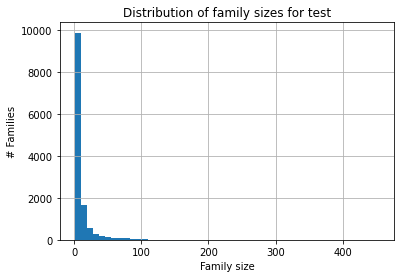

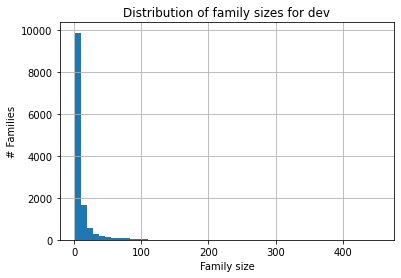

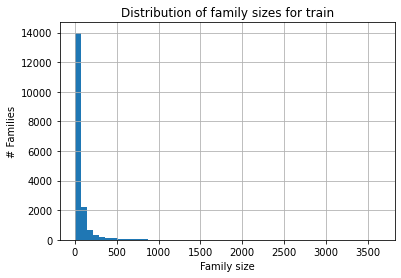

In [ ]:
for title, partition in partitions.items():
    partition.groupby('family_id').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % title)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()


Above distribution of family sizes plot shows that the greater the family size lesser the no. of the same.


In [ ]:
all_data.family_id.describe()

count             1339083
unique              17929
top       Methyltransf_25
freq                 4545
Name: family_id, dtype: object

 Family 'Methyltransf_25' has occurred highest nummer

In [ ]:
all_data.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    4545
LRR_1              2407
Acetyltransf_7     2199
His_kinase         1921
Bac_transf         1908
Lum_binding        1878
DNA_binding_1      1681
Chromate_transp    1579
Lipase_GDSL_2      1564
DnaJ_CXXCXGXG      1512
dtype: int64

In [ ]:
# Number of letters in each sequence
all_data['sequence_length'] = all_data.sequence.str.len()

In [ ]:
all_data

,family_id,sequence_name,family_accession,sequence,sequence_length
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...,235
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...,136
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...,98
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...,201
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...,88
...,...,...,...,...,...
13510,DUF4276,B1Y1D3_LEPCP/11-206,PF14103.6,VEEPSMEAFLHALLPRLMPARRTFEIHPFQGKDDLMAKLEARLRAY...,196
13511,Lipoprotein_3,Y645_MYCPN/25-108,PF00938.17,AATQVISSLSSAQKYFESSQGELNKKNVIKILKEGYESDANKAVHA...,84
13512,Ribosomal_S6,I4DCK0_DESAJ/3-92,PF01250.17,AYEILYIIRPDMDEEATNALVDRLSGLAASNGGQNVTVDKWGKRRL...,90
13513,Sterile,K7J1J9_NASVI/384-476,PF03015.19,LDYVPALVADLLAVLHGNAPDSWALLRESMGDMCRLHRFSSGNWRI...,93


In [ ]:
## Following code creat a dataframe containing top 10 no (size) of sequence name
# Source https://stackoverflow.com/a/27975230
# Source https://stackoverflow.com/a/19170098
# Source https://pythonspot.com/pandas-filter/
# Source https://www.w3schools.com/python/python_regex.asp

top_size_seq1 = pd.DataFrame(all_data[all_data.family_id.str.contains("Methyltransf_25|Acetyltransf_7|His_kinase|Bac_transf|Lum_binding|DNA_binding_1|Chromate_transp|Lipase_GDSL_2|DnaJ_CXXCXGXG|LRR_1$")])
top_size_seq1

,family_id,sequence_name,family_accession,sequence,sequence_length
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...,98
35,DNA_binding_1,Q7UU90_RHOBA/63-138,PF01035.20,MRTAFVRTIEELRPGEVVSYGDVAARAGYPRRHRAVGQLLGASFDA...,76
120,Methyltransf_25,R5XZC5_9PROT/345-436,PF13649.6,ILDLGCGTGLCAEALRAYFPNEEFFGVDVSEKMLEFAGKKNVYKEL...,92
147,His_kinase,D9R4C7_CLOSW/291-370,PF06580.13,AQLQLIKSQLNPHFLFNTLNMITRMAQMEEAPVTEEMLVAISNLLR...,80
148,Acetyltransf_7,L7W881_NONDD/44-129,PF13508.7,GLQHVIVAYLNDVAVGCGALRPFDKETMEVKRMFTLVDYRGKGIAS...,86
...,...,...,...,...,...
13338,Methyltransf_25,I2FZ93_USTH4/43-146,PF13649.6,ILDYGCGSGEITLDLATIVGPDGEVTGLDASDDMIIKACNLHASHP...,104
13339,His_kinase,C0Z9T0_BREBN/333-412,PF06580.13,AELRAVHYQINPHLLFNTLNSIQWKARLSGANEIGNMLYHLIKVLE...,80
13383,Methyltransf_25,F0YGD9_AURAN/710-812,PF13649.6,ILELGSGGGRDAVELARSRVGIDFVGVDGSAGMCGLAAARAEQRKV...,103
13455,Lum_binding,A4S0H5_OSTLU/101-187,PF00677.17,SGHVHCTAEIVEVVDSEHNRKVVFETSDRALIKYVLPKGFIAIDGC...,87


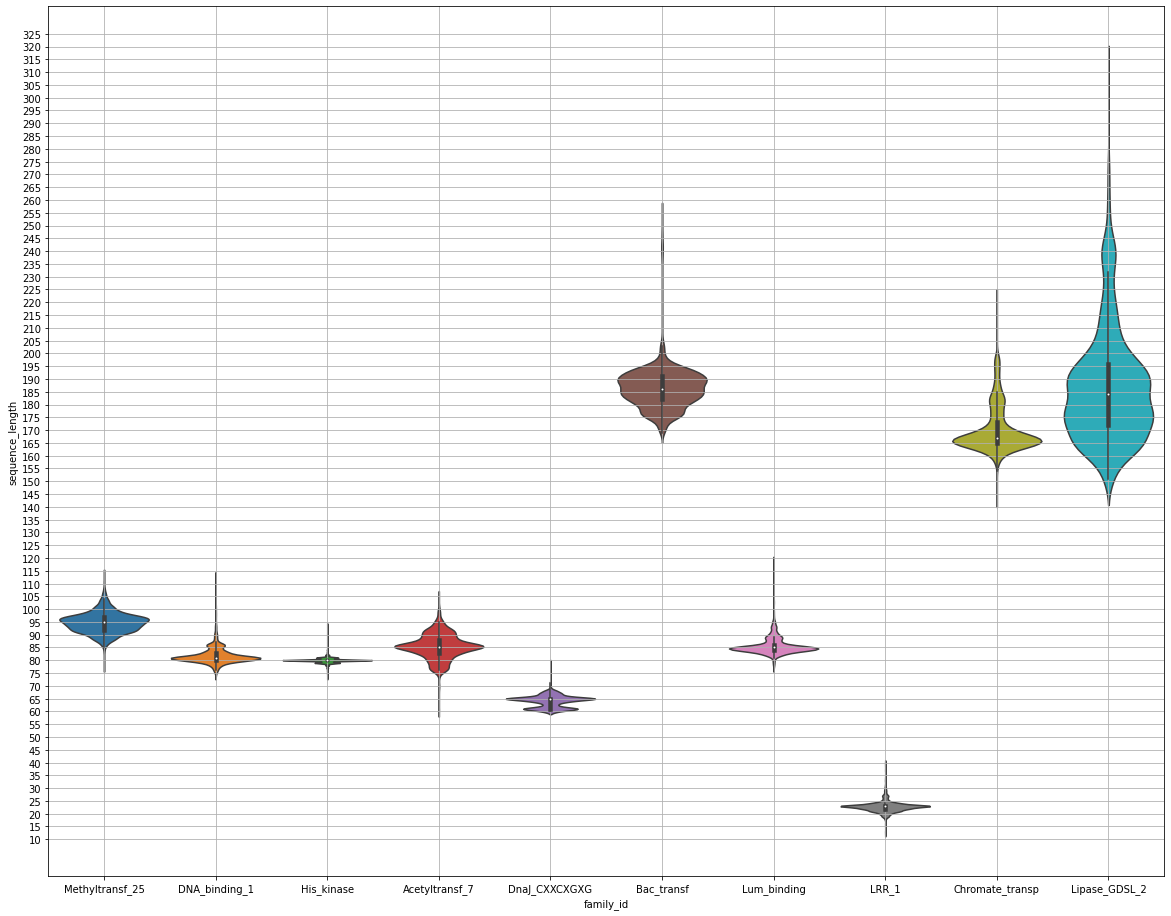

In [ ]:
# violin plot
# Source https://stackoverflow.com/a/50671064
# Source https://seaborn.pydata.org/generated/seaborn.violinplot.html 

plt.figure(figsize=(20,16))# SIZE OF THE PLOT
ax = sns.violinplot(x = 'family_id', y = 'sequence_length', data = top_size_seq1,scale="width")
ax.set_yticks(np.arange(10, 330, 5)) # Scale of the gride i.e. starting range, max range, difference respectively
plt.grid()

From the above plot, 'Lipase_GDSL_2' has most of the largest number of the longest protein sequence and on the other hand 'LRR_1' (Leucine Rich Repeat Protein 1) has the shotest length in amino acid as compare to others.

# A small explanation  on Methyltransf_25

In [ ]:
all_data[all_data.family_id.str.contains("Methyltransf_25")].describe()

,sequence_length
count,4545.000000
mean,94.779758
std,4.029942
min,77.000000
25%,92.000000
50%,95.000000
75%,97.000000
max,114.000000


 Family id 'Methyltransf_25' has the heightest number of sequence having range 77 to 114 and average is 95 in length (no. of amino acids) . 

In [ ]:
all_data.sort_values(["sequence_length"], axis=0, ascending=False) # Descending order of sequence length

,family_id,sequence_name,family_accession,sequence,sequence_length
8189,Arena_RNA_pol,L_LASSJ/178-2214,PF06317.11,FEESEYSRLCESLFMTSGRLSGVESLNVLMDNRSNHYEEVIASCHQ...,2037
9930,Arena_RNA_pol,L_LYCVA/178-2207,PF06317.11,FEESEYFRLCESLKTTIDKRSGMDSMKILKDARSTHNDEIMRMCHE...,2030
8746,Arena_RNA_pol,L_TACVF/179-2207,PF06317.11,IEDQEYQRLIHSLSNVRNQSLGFENIECLKRNLLEYDDRLAKSLFV...,2029
11230,GREB1,C3Y162_BRAFL/57-2028,PF15782.5,MGNTHGQLKSSRFEAALHSSIEQSLRSQDVAPRPVFSQLYLDKQQG...,1972
9434,GREB1,I3KKK4_ORENI/1-1971,PF15782.5,MGNSYAGQLRTTRFEEVLHNSIEASLRSNTIIPRPVFSQLYLETEQ...,1971
...,...,...,...,...,...
10446,Octapeptide,SPA_STAA8/326-333,PF03373.14,PKEEDNNK,8
10174,WWamide,WWA1_ACHFU/1-7,PF08258.11,WREMSVW,7
844,WWamide,WWA2_ACHFU/1-7,PF08258.11,WKQMSVW,7
2327,DNA_pol_lambd_f,F1SE21_PIG/22-27,PF10391.9,VTGVAG,6


In [ ]:
all_data.sequence_length.describe()

count    1.339083e+06
mean     1.551566e+02
std      1.197877e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence_length, dtype: float64

Family ID 'Arena_RNA_pol' has the longest sequence length of 2037 and the minimum number of amino acid (length) is 4, however average length is approx 155 amino acids long

In [ ]:
# Source https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html
all_data[all_data.sequence_length==4]

,family_id,sequence_name,family_accession,sequence,sequence_length
4901,DUF4744,B5DLN4_DROPS/115-118,PF15918.5,TATK,4


Only one protein family has 4 length of amino acid in whole file.

### EDA on Methyltransf_25

In [ ]:
Methyltransf_25_df = pd.DataFrame(all_data[all_data.family_id.str.contains("Methyltransf_25")])
Methyltransf_25_df

,family_id,sequence_name,family_accession,sequence,sequence_length
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...,98
120,Methyltransf_25,R5XZC5_9PROT/345-436,PF13649.6,ILDLGCGTGLCAEALRAYFPNEEFFGVDVSEKMLEFAGKKNVYKEL...,92
479,Methyltransf_25,R6Z571_9FIRM/47-138,PF13649.6,VLDLGCGFGEHCMRCIRQGAEKVVGIDISEKMLEVARKENSDARIT...,92
1150,Methyltransf_25,F4LU06_TEPAE/40-133,PF13649.6,ILDVGTGTGVMIPYIYEMIGDEGEIIAIDLAEKMLEVARQKYPFNN...,94
1245,Methyltransf_25,R4KE08_9FIRM/34-131,PF13649.6,ALDVACGYGETAIMLASLGVEVVSLGTDPRIVERAKHRAVEAGHNP...,98
...,...,...,...,...,...
12511,Methyltransf_25,I6XT35_PSEPQ/229-335,PF13649.6,ILDIGCATGQTLKLLSELPGLFESDFYGVESARPLLEVCQQRRSDG...,107
13011,Methyltransf_25,A1B7C7_PARDP/24-126,PF13649.6,VLEIGCGPGVAAREVSRRVGNGFVLAIDRSAKAIESAVAGSKAEIA...,103
13118,Methyltransf_25,I3VUY9_THESW/50-141,PF13649.6,ILEAGIGTGSNILYYPEGKNIYGIDFSPKMVEIAKDKAKRYGKDVD...,92
13338,Methyltransf_25,I2FZ93_USTH4/43-146,PF13649.6,ILDYGCGSGEITLDLATIVGPDGEVTGLDASDDMIIKACNLHASHP...,104


In [ ]:
#Methyltransf_25_df.sequence.str.contains("A").count()
# https://stackoverflow.com/a/17574265
Methyltransf_25_df.sequence.str.count("A")

2        13
120       9
479       5
1150      6
1245      9
         ..
12511     6
13011    17
13118     4
13338     8
13383    12
Name: sequence, Length: 4545, dtype: int64

In [ ]:
# Contains total no. of Alanine in whole Methyltransf_25 protein family fron all file
#https://stackoverflow.com/a/17574265
Methyltransf_25_df_A = Methyltransf_25_df.sequence.str.count("A").sum() 
Methyltransf_25_df_A

44449

In [ ]:
# Contains total no. of protein in whole Methyltransf_25 protein family fron all file
#https://stackoverflow.com/a/17574265
#https://stackoverflow.com/a/9072937

Methyltransf_25_df_tot_prot = Methyltransf_25_df.sequence.str.count(r'[A-Z]').sum()
Methyltransf_25_df_tot_prot

430774

In [ ]:
# Percentage of alanine
100*Methyltransf_25_df_A/Methyltransf_25_df_tot_prot

10.318403617674234

In [ ]:
# Percentage of Aspartic acid
100*Methyltransf_25_df.sequence.str.count("D").sum()/Methyltransf_25_df.sequence.str.count(r'[A-Z]').sum()

7.110689131656042

### Percentage of Amino acid in Methyltransf_25

In [ ]:
#Code is about total no. of All the amino acid in whole Methyltransf_25 protein family fron all file
##https://python-forum.io/Thread-build-pandas-dataframe-from-a-for-loop
import pandas as pd
aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
dfA = pd.DataFrame({'Amino acid': [], 'No. of Amino acid': [], '% of Amino acid': []})
for i in aa:
    dfA = dfA.append({'Amino acid': i, 'No. of Amino acid': Methyltransf_25_df.sequence.str.count(i).sum(), 
                    '% of Amino acid': 100*Methyltransf_25_df.sequence.str.count(i).sum()/
                    Methyltransf_25_df.sequence.str.count(r'[A-Z]').sum()}, 
                   ignore_index=True)
dfA

,Amino acid,No. of Amino acid,% of Amino acid
0,A,44449.0,10.318404
1,C,9148.0,2.123619
2,D,30631.0,7.110689
3,E,25108.0,5.828578
4,F,18447.0,4.282292
5,G,39650.0,9.204362
6,H,10610.0,2.463008
7,I,22959.0,5.329709
8,K,16599.0,3.853297
9,L,47003.0,10.911290


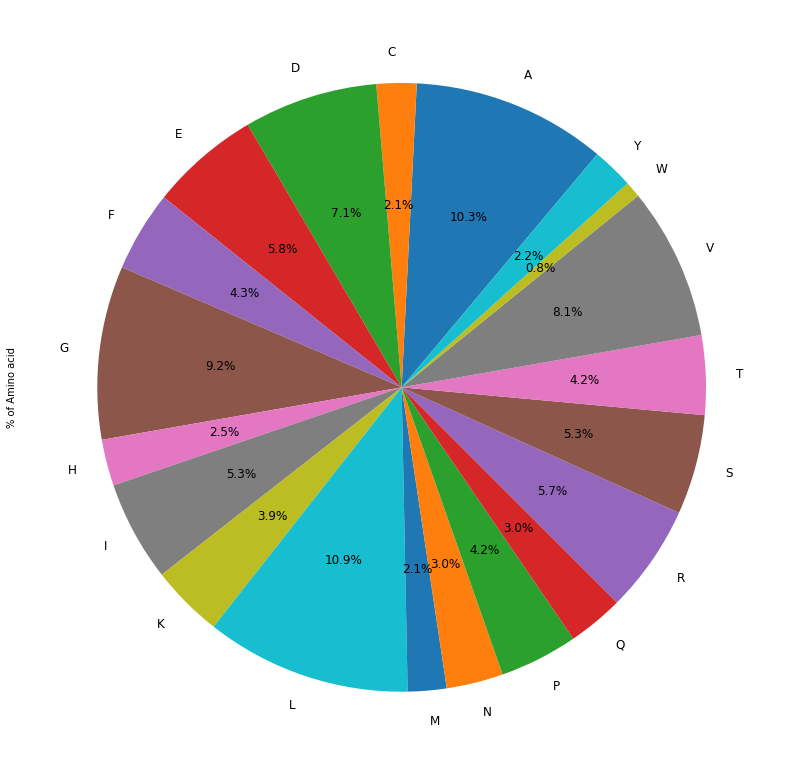

In [ ]:
##https://stackoverflow.com/a/38340448
##https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pie.html
##https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html



plt.figure(figsize=(30,15))
# plot chart
ax1 = plt.subplot(121, aspect='equal')

dfA.plot(kind='pie', y = '% of Amino acid', ax=ax1, autopct='%1.1f%%', 
 startangle=50, shadow=False, labels=dfA['Amino acid'], legend = False, fontsize=12)

########################################Note###################################################################
#startangle:- rotates the start of the pie chart by angle degrees counterclockwise from the x-axis
#autopct:- is a string or function used to label the wedges with their numeric value. 
#The label will be placed inside the wedge. If it is a format string, the label will be fmt%pct. 
#If it is a function, it will be called
#pos:- 121 or 1,2,1 pos is a three digit integer, where the first digit is the number of rows, 
#the second the number of columns, and the third the index of the subplot.

Alanine (A) and Lysine (L) has more chunk on the pie of Methyltransf_25 family in all total file